Обучить СНС с помощью Transfer Learning на датасете Food-101

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

### **food101**

Описание:

Этот набор данных состоит из 101 категории продуктов питания и 101 000 изображений. 

Для каждого класса предоставляется 250 проверенных вручную тестовых изображений, а также 750 обучающих изображений. 

Учебные изображения намеренно не очищались и поэтому все еще содержат некоторое количество шума. В основном это проявляется в виде интенсивных цветов и иногда неправильных этикеток. 

Все изображения были масштабированы таким образом, чтобы максимальная длина стороны составляла 512 пикселей.

In [ ]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:50%]', 'train[90%:]' ]
)

### **Визуализация**

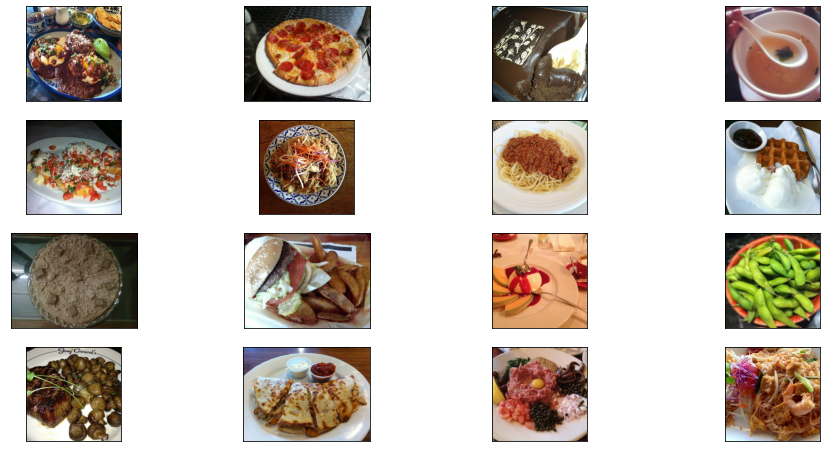

In [ ]:
some_samples = [x[0] for x in iter(train_ds.take(16))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 4, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Пайплайн данных

In [ ]:
INP_SIZE = 256
NUM_EPOCHS = 8
BATCH_SIZE = 256

In [ ]:
def prepare(img, label):
    img = tf.cast(img, tf.float32) / 255.
    label = tf.one_hot(indices=tf.cast(label, tf.int32), depth=101)
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

def custom_augmentation(image,label):
    augment = np.random.choice([0, 1])
    if augment:
        return image, label

    flip_left_right, central_crop, rot90, random_saturation = \
        np.random.choice([0, 1], size=4)

    if flip_left_right:
        image = tf.image.flip_left_right(image)
    
    if random_saturation:
        image = tf.image.random_saturation(image, 0.1, 3)

    return image, label


In [ ]:
train_ds = train_ds.shuffle(buffer_size=10000)
train_ds = train_ds.map(custom_augmentation)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=10000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine Tuning весов предобученной модели   
# base_model.trainable = False # заморозка весов предобученной модели 

# Размораживаем последний 5-й свёрточный блок
trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(101, activation='softmax')
])

In [ ]:
LEARNING_RATE = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 101)               13029     
                                                                 
Total params: 14,793,381
Trainable params: 7,158,117
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds
)

Epoch 1/8
147/147 [==============================] - 431s 3s/step - loss: 4.0413 - accuracy: 0.1116 - val_loss: 3.4138 - val_accuracy: 0.2131
Epoch 2/8
147/147 [==============================] - 380s 2s/step - loss: 3.0322 - accuracy: 0.2834 - val_loss: 2.8538 - val_accuracy: 0.3215
Epoch 3/8
147/147 [==============================] - 359s 2s/step - loss: 2.5533 - accuracy: 0.3809 - val_loss: 2.5349 - val_accuracy: 0.3922
Epoch 4/8
147/147 [==============================] - 360s 2s/step - loss: 2.2601 - accuracy: 0.4458 - val_loss: 2.3556 - val_accuracy: 0.4269
Epoch 5/8
147/147 [==============================] - 360s 2s/step - loss: 2.0627 - accuracy: 0.4872 - val_loss: 2.2560 - val_accuracy: 0.4512
Epoch 6/8
147/147 [==============================] - 380s 2s/step - loss: 1.9022 - accuracy: 0.5232 - val_loss: 2.1302 - val_accuracy: 0.4821
Epoch 7/8
147/147 [==============================] - 359s 2s/step - loss: 1.7645 - accuracy: 0.5538 - val_loss: 2.1411 - val_accuracy: 0.4743
Epoch 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

29/29 [==============================] - 60s 2s/step - loss: 2.0801 - accuracy: 0.4884


Все же это лучше чем 0.0099 (1/101 классов)